# European Social Survey (Round 11) - Trust Variables Dimensional Reduction

Ondřej Marvan, 477001  

## Project Overview

This analysis explores the latent structure of trust-related variables in the European Social Survey (ESS) Round 11 data using **Principal Component Analysis (PCA)** and **Factor Analysis**. The goal is to discover how different types of trust—institutional, political, and social—relate to each other and how they vary across European countries.

### Variables Analyzed (0-10 scale):
| Variable | Description |
|----------|-------------|
| `trstplt` | Trust in politicians |
| `trstplc` | Trust in the police |
| `trstprl` | Trust in country's parliament |
| `trstprt` | Trust in political parties |
| `trstlgl` | Trust in the legal system |
| `trstep` | Trust in the European Parliament |
| `trstun` | Trust in the United Nations |
| `ppltrst` | Social trust (people can be trusted) |
| `pplhlp` | People are helpful |
| `pplfair` | People are fair |

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Done")

Libraries loaded successfully!


## 1. Data Loading and Preparation

In [2]:
# Data Path - main.csv
data_path = "/home/ondrej-marvan/Documents/GitHub/OBS_DataScience/OBS_DataScience/Autumn 2025/2400-DS1UL Unsupervised Learning/Projects/Task_DimReduction/Data/main.csv"

# Load data
df = pd.read_csv(data_path, low_memory=False)
print(f"Dataset shape: {df.shape}")
print(f"Number of respondents: {df.shape[0]:,}")

Dataset shape: (50116, 691)
Number of respondents: 50,116


In [22]:
# Define trust variables and labels
trust_vars = ['trstplt', 'trstplc', 'trstprl', 'trstprt', 'trstlgl', 
              'trstep', 'trstun', 'ppltrst', 'pplhlp', 'pplfair']

var_labels = {
    'trstplt': 'Trust Politicians',
    'trstplc': 'Trust Police',
    'trstprl': 'Trust Parliament',
    'trstprt': 'Trust Parties',
    'trstlgl': 'Trust Legal System',
    'trstep': 'Trust EU Parliament',
    'trstun': 'Trust UN',
    'ppltrst': 'Social Trust',
    'pplhlp': 'People Helpful',
    'pplfair': 'People Fair'
}

country_names = {
    'AT': 'Austria', 'BE': 'Belgium', 'BG': 'Bulgaria', 'CH': 'Switzerland',
    'CY': 'Cyprus', 'CZ': 'Czechia', 'DE': 'Germany', 'DK': 'Denmark',
    'EE': 'Estonia', 'ES': 'Spain', 'FI': 'Finland', 'FR': 'France',
    'GB': 'United Kingdom', 'GR': 'Greece', 'HR': 'Croatia', 'HU': 'Hungary',
    'IE': 'Ireland', 'IS': 'Iceland', 'IL': 'Israel', 'IT': 'Italy', 'LT': 'Lithuania',
    'LV': 'Latvia', 'ME': 'Montenegro', 'NL': 'Netherlands', 'NO': 'Norway',
    'PL': 'Poland', 'PT': 'Portugal', 'RS': 'Serbia', 'SE': 'Sweden',
    'SI': 'Slovenia', 'SK': 'Slovakia', 'UA': 'Ukraine', 'XK': 'Kosovo'
}

## 2. Geographical Coverage

Keeping the **broadest possible geographical coverage** - all countries in the dataset.

In [23]:
# Get all countries
countries = df['cntry'].unique()
print(f"Countries in dataset: {len(countries)}")
print(f"\nCountry codes: {sorted(countries)}")

# Sample sizes per country
print("\n" + "="*50)
print("Sample Sizes by Country:")
print("="*50)
country_counts = df['cntry'].value_counts().sort_index()
for code, count in country_counts.items():
    name = country_names.get(code, code)
    print(f"{code} ({name}): {count:,}")

Countries in dataset: 30

Country codes: ['AT', 'BE', 'BG', 'CH', 'CY', 'DE', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IL', 'IS', 'IT', 'LT', 'LV', 'ME', 'NL', 'NO', 'PL', 'PT', 'RS', 'SE', 'SI', 'SK', 'UA']

Sample Sizes by Country:
AT (Austria): 2,354
BE (Belgium): 1,594
BG (Bulgaria): 2,239
CH (Switzerland): 1,384
CY (Cyprus): 685
DE (Germany): 2,420
EE (Estonia): 1,293
ES (Spain): 1,844
FI (Finland): 1,563
FR (France): 1,771
GB (United Kingdom): 1,684
GR (Greece): 2,757
HR (Croatia): 1,563
HU (Hungary): 2,118
IE (Ireland): 2,017
IL (Israel): 906
IS (Iceland): 842
IT (Italy): 2,865
LT (Lithuania): 1,365
LV (Latvia): 1,252
ME (Montenegro): 1,609
NL (Netherlands): 1,695
NO (Norway): 1,337
PL (Poland): 1,442
PT (Portugal): 1,373
RS (Serbia): 1,563
SE (Sweden): 1,230
SI (Slovenia): 1,248
SK (Slovakia): 1,442
UA (Ukraine): 2,661


Missing countries like 

Belarus (BY)
Czechia (CZ) - EU member stete
Denmark (DK) - EU member state
Luxembourg (LU)
Malta (MT) - EU member state
Romania (RO) - EU member state

## 3. Variable Inspection

In [5]:
# Working subset create
df_trust = df[['cntry'] + trust_vars].copy()

# Solve missing values (ESS uses codes 66, 77, 88, 99 for missing)
# Valid values are 0-10
print("Missing values:")
print("-" * 50)
for var in trust_vars:
    df_trust[var] = pd.to_numeric(df_trust[var], errors='coerce')
    # Replace values outside 0-10 range with NaN
    invalid_mask = (df_trust[var] < 0) | (df_trust[var] > 10)
    df_trust.loc[invalid_mask, var] = np.nan
    n_missing = df_trust[var].isna().sum()
    pct_missing = (n_missing / len(df_trust)) * 100
    print(f"{var_labels[var]:20s}: {n_missing:,} missing ({pct_missing:.1f}%)")

Checking for missing/invalid values:
--------------------------------------------------
Trust Politicians   : 779 missing (1.6%)
Trust Police        : 575 missing (1.1%)
Trust Parliament    : 998 missing (2.0%)
Trust Parties       : 950 missing (1.9%)
Trust Legal System  : 1,149 missing (2.3%)
Trust EU Parliament : 3,366 missing (6.7%)
Trust UN            : 3,821 missing (7.6%)
Social Trust        : 144 missing (0.3%)
People Helpful      : 174 missing (0.3%)
People Fair         : 326 missing (0.7%)


There are many missing values for Trust in the EU Parliament (6.7%). This makes sense because several countries in our list are not EU members, like Iceland (IS), Norway (NO), Switzerland (CH), the United Kingdom (GB), and Ukraine (UA). There are even more missing values for Trust in the UN (7.6%). This is likely because the UN feels very far away from people's daily lives, so it is hard for them to have a clear opinion or give a score.

In [6]:
# Descriptive statistics
print("\nDescriptive Statistics:")
print("="*70)
stats = df_trust[trust_vars].describe().round(2)
stats.columns = [var_labels[v] for v in trust_vars]
display(stats)


Descriptive Statistics:


,Trust Politicians,Trust Police,Trust Parliament,Trust Parties,Trust Legal System,Trust EU Parliament,Trust UN,Social Trust,People Helpful,People Fair
count,49337.00,49541.00,49118.00,49166.00,48967.00,46750.00,46295.00,49972.00,49942.00,49790.00
mean,3.52,6.25,4.32,3.50,5.26,4.57,4.94,4.98,4.96,5.57
std,2.49,2.58,2.71,2.45,2.75,2.61,2.68,2.48,2.36,2.30
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,5.00,2.00,1.00,3.00,3.00,3.00,3.00,3.00,4.00
50%,4.00,7.00,5.00,3.00,6.00,5.00,5.00,5.00,5.00,6.00
75%,5.00,8.00,6.00,5.00,7.00,7.00,7.00,7.00,7.00,7.00
max,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00


The results show that the Police are the most trusted group with a score of 6.25. On the other hand, Politicians (3.52) and Parties (3.50) have the lowest trust from the people. Even though many people skipped the question about the UN, those who answered gave it a better score (4.94) than the EU Parliament (4.57). Most of the other scores for social trust are in the middle, around 5.0.

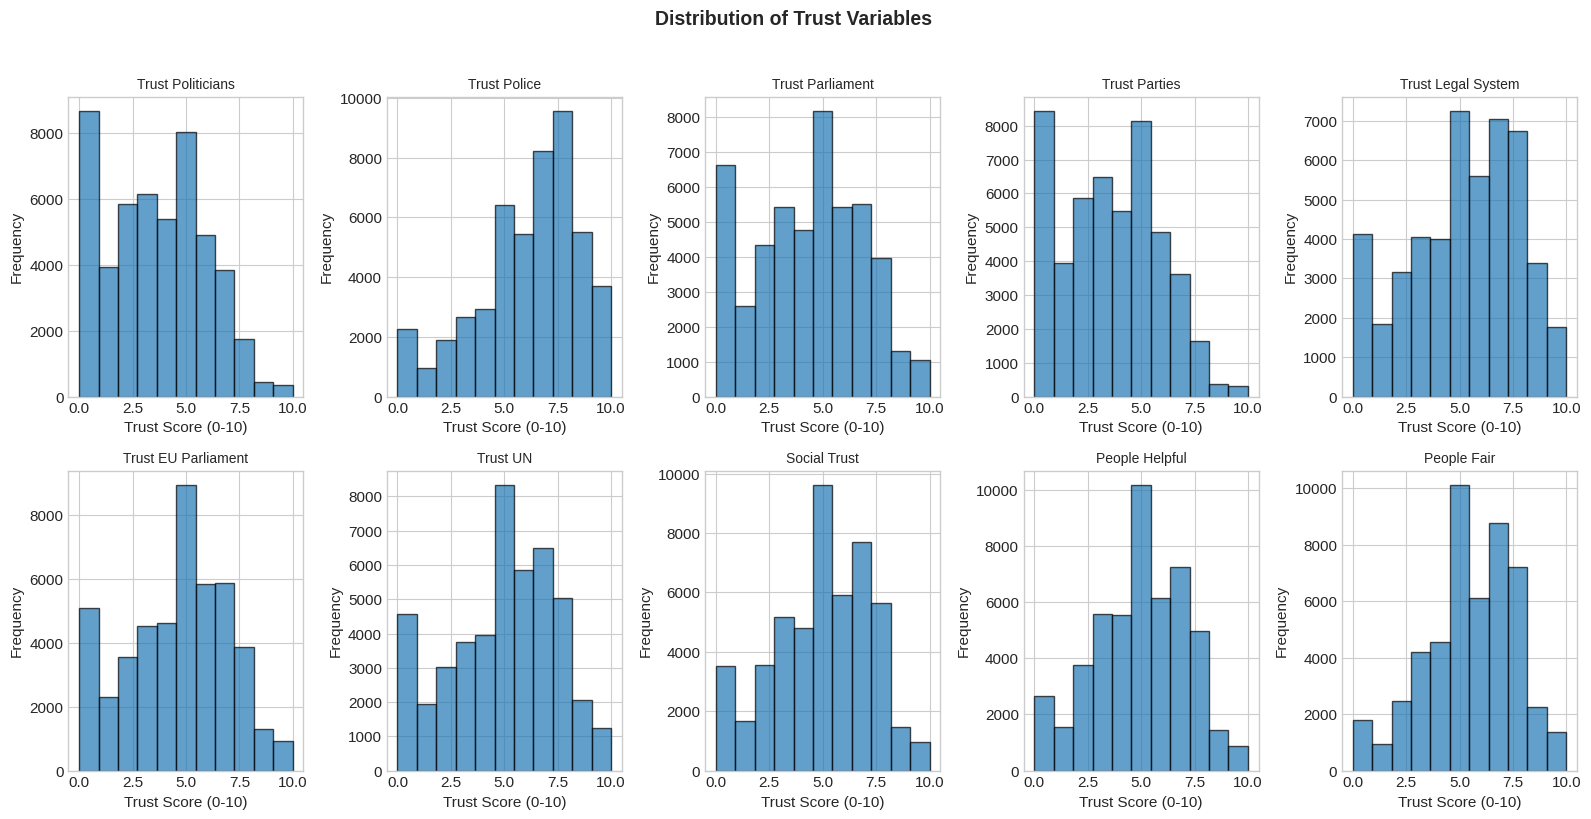

In [7]:
# Distribution of trust variables
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
axes = axes.flatten()

for i, var in enumerate(trust_vars):
    df_trust[var].dropna().hist(bins=11, ax=axes[i], edgecolor='black', alpha=0.7)
    axes[i].set_title(var_labels[var], fontsize=10)
    axes[i].set_xlabel('Trust Score (0-10)')
    axes[i].set_ylabel('Frequency')

plt.suptitle('Distribution of Trust Variables', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Trust Politicians (extreme distrust, many people gave 0), Trust Police (positive skew, most people gave 7), Trust EU Parliament (neutrality), People Fair (social optimism), Social Trust (mid peak)

## 4. Data Preparation for PCA

In [3]:
# Case analysis
df_complete = df_trust.dropna(subset=trust_vars)
print(f"Complete cases: {len(df_complete):,} out of {len(df_trust):,} ({100*len(df_complete)/len(df_trust):.1f}%)")
print(f"Countries with complete data: {df_complete['cntry'].nunique()}")

# Extract and standardize features
X = df_complete[trust_vars].values
countries_complete = df_complete['cntry'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"\nFeature matrix shape: {X_scaled.shape}")
print("Data standardized (mean=0, std=1)")

NameError: name 'df_trust' is not defined

**43,744 rows**, so your data is still very strong for analysis.

## 5. Principal Component Analysis

In [9]:
# Fit PCA
pca = PCA()
pca.fit(X_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
eigenvalues = pca.explained_variance_

# Kaiser criterion
n_kaiser = sum(eigenvalues > 1)

print("Explained Variance by Component:")
print("="*60)
for i, (var, cum, eig) in enumerate(zip(explained_var, cumulative_var, eigenvalues), 1):
    kaiser = "*" if eig > 1 else " "
    bar = '█' * int(var * 40)
    print(f"PC{i}: {var*100:5.1f}%  (cum: {cum*100:5.1f}%)  λ={eig:.2f} {kaiser} {bar}")

print(f"\n* Kaiser criterion (eigenvalue > 1): Retain {n_kaiser} components")

Explained Variance by Component:
PC1:  51.3%  (cum:  51.3%)  λ=5.13 * ████████████████████
PC2:  15.0%  (cum:  66.3%)  λ=1.50 * ██████
PC3:   8.2%  (cum:  74.5%)  λ=0.82   ███
PC4:   7.2%  (cum:  81.7%)  λ=0.72   ██
PC5:   4.9%  (cum:  86.6%)  λ=0.49   █
PC6:   4.0%  (cum:  90.6%)  λ=0.40   █
PC7:   3.2%  (cum:  93.8%)  λ=0.32   █
PC8:   2.6%  (cum:  96.3%)  λ=0.26   █
PC9:   2.4%  (cum:  98.8%)  λ=0.24   
PC10:   1.2%  (cum: 100.0%)  λ=0.12   

* Kaiser criterion (eigenvalue > 1): Retain 2 components


In [4]:
# Scree plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Eigenvalues
ax1 = axes[0]
ax1.plot(range(1, len(eigenvalues)+1), eigenvalues, 'bo-', linewidth=2, markersize=10)
ax1.axhline(y=1, color='r', linestyle='--', linewidth=2, label='Kaiser criterion (λ=1)')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Eigenvalue', fontsize=12)
ax1.set_title('Scree Plot', fontsize=14, fontweight='bold')
ax1.set_xticks(range(1, len(eigenvalues)+1))
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Cumulative variance
ax2 = axes[1]
# Bars
ax2.bar(range(1, len(explained_var)+1), explained_var*100, color='steelblue', alpha=0.7)

# Title
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Variance Explained (%)')
ax2.set_title('Variance Explained', fontweight='bold')

# Set the x-axis numbers and add a light grid
ax2.set_xticks(range(1, len(explained_var)+1))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

## 6. Component Loadings Analysis

In [11]:
# Component loadings
loadings = pca.components_[:n_kaiser].T
loadings_df = pd.DataFrame(
    loadings,
    index=[var_labels[v] for v in trust_vars],
    columns=[f'PC{i+1}' for i in range(n_kaiser)]
)

print(f"Component Loadings (retaining {n_kaiser} components):")
print("="*60)
display(loadings_df.round(3))

Component Loadings (retaining 2 components):


,PC1,PC2
Trust Politicians,0.373,-0.169
Trust Police,0.308,-0.061
Trust Parliament,0.368,-0.136
Trust Parties,0.368,-0.175
Trust Legal System,0.349,-0.089
Trust EU Parliament,0.318,-0.244
Trust UN,0.315,-0.216
Social Trust,0.253,0.505
People Helpful,0.231,0.506
People Fair,0.236,0.542


PC1 represents a "General Trust" score because all variables have positive numbers and move in the same direction. PC2 is very interesting because it shows a split between two different feelings. Difference between Social Trust (PC2 is positive) and Politicians Trust (PC2 is negative), etc. 

In [12]:
print("\nComponent Interpretation:")
print("="*60)
for i in range(n_kaiser):
    print(f"\nPC{i+1} ({explained_var[i]*100:.1f}% variance):")
    print("-" * 40)
    # Descending order (from strong to weak)
    pc_loadings = loadings_df[f'PC{i+1}'].sort_values(key=abs, ascending=False)
    for var, load in pc_loadings.items():
        # Print
        print(f"  {var}: {load:+.3f}")


Component Interpretation:

PC1 (51.3% variance):
----------------------------------------
  + Trust Politicians: +0.373 (moderate)
  + Trust Parliament: +0.368 (moderate)
  + Trust Parties: +0.368 (moderate)
  + Trust Legal System: +0.349 (moderate)
  + Trust EU Parliament: +0.318 (moderate)
  + Trust UN: +0.315 (moderate)
  + Trust Police: +0.308 (moderate)
  + Social Trust: +0.253 (weak)
  + People Fair: +0.236 (weak)
  + People Helpful: +0.231 (weak)

PC2 (15.0% variance):
----------------------------------------
  + People Fair: +0.542 (STRONG)
  + People Helpful: +0.506 (STRONG)
  + Social Trust: +0.505 (STRONG)
  - Trust EU Parliament: -0.244 (weak)
  - Trust UN: -0.216 (weak)
  - Trust Parties: -0.175 (weak)
  - Trust Politicians: -0.169 (weak)
  - Trust Parliament: -0.136 (weak)
  - Trust Legal System: -0.089 (weak)
  - Trust Police: -0.061 (weak)


## 7. Factor Analysis (Comparison with Varimax Rotation)

In [14]:
# Factor Analysis with Varimax rotation
fa = FactorAnalysis(n_components=n_kaiser, rotation='varimax', random_state=42)
fa.fit(X_scaled)

fa_loadings = pd.DataFrame(
    fa.components_.T,
    index=[var_labels[v] for v in trust_vars],
    columns=[f'Factor{i+1}' for i in range(n_kaiser)]
)

print(f"Factor Loadings (Varimax Rotation, {n_kaiser} factors):")
print("="*60)
display(fa_loadings.round(3))

Factor Loadings (Varimax Rotation, 2 factors):


,Factor1,Factor2
Trust Politicians,0.912,-0.168
Trust Police,0.526,-0.297
Trust Parliament,0.789,-0.245
Trust Parties,0.900,-0.157
Trust Legal System,0.643,-0.308
Trust EU Parliament,0.629,-0.167
Trust UN,0.582,-0.202
Social Trust,0.241,-0.731
People Helpful,0.222,-0.644
People Fair,0.190,-0.749


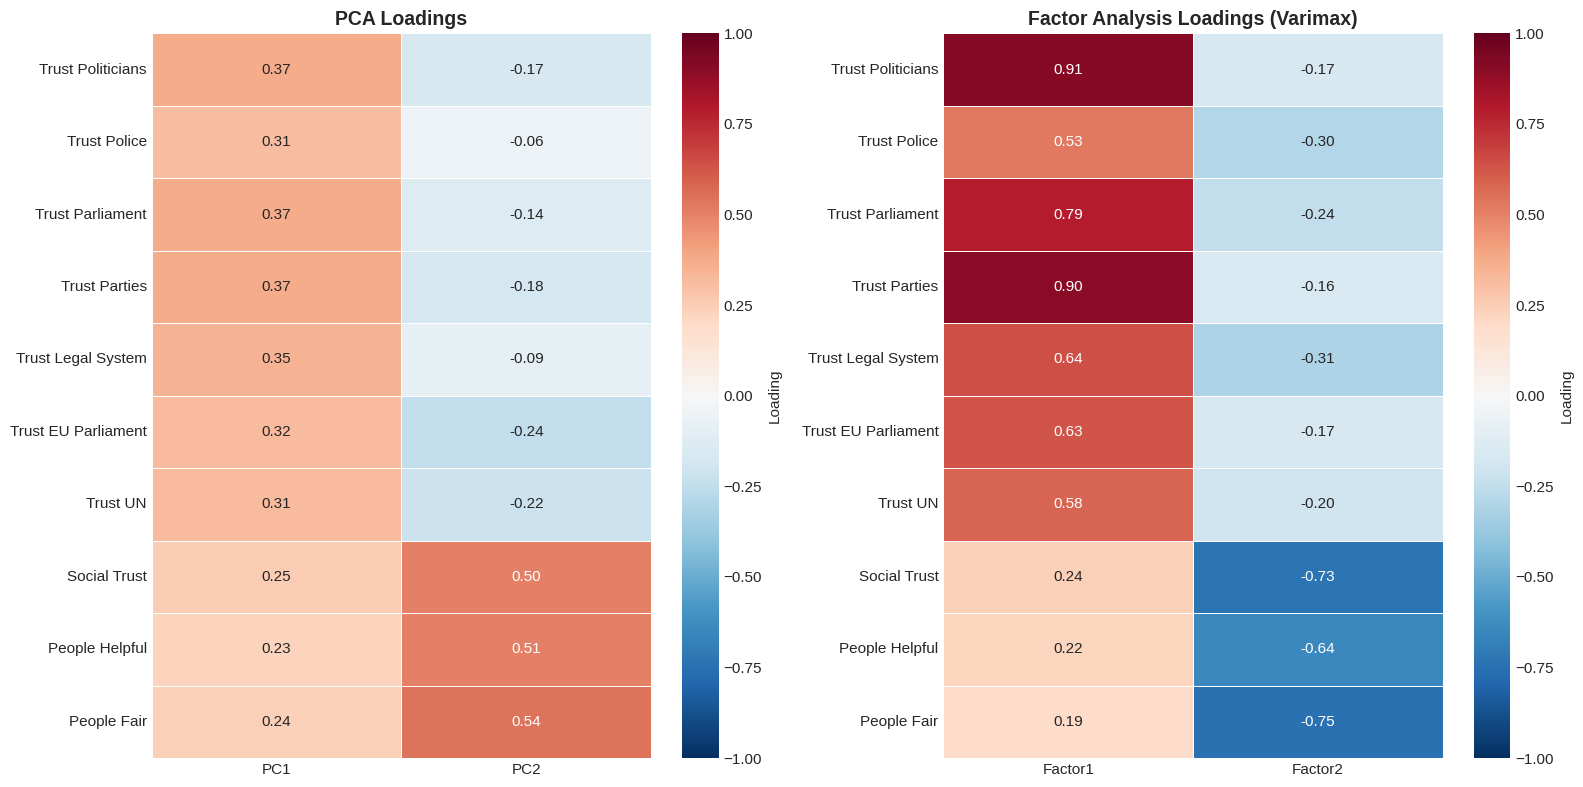

In [15]:
# Compare PCA and FA loadings
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(loadings_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, ax=axes[0], cbar_kws={'label': 'Loading'}, linewidths=0.5)
axes[0].set_title('PCA Loadings', fontsize=14, fontweight='bold')

sns.heatmap(fa_loadings, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': 'Loading'}, linewidths=0.5)
axes[1].set_title('Factor Analysis Loadings (Varimax)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Dimension Reduction Visualization

In [16]:
# Transform data to 2D
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_scaled)

df_pca = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Country': countries_complete
})

# Country means
country_means = df_pca.groupby('Country').agg({'PC1': 'mean', 'PC2': 'mean'}).reset_index()
country_means['Country_Name'] = country_means['Country'].map(country_names)

print("Country Positions in PCA Space:")
print("="*50)
display(country_means.sort_values('PC1', ascending=False).round(3))

Country Positions in PCA Space:


,Country,PC1,PC2,Country_Name
8,FI,2.148,0.353,Finland
22,NO,2.107,0.167,Norway
26,SE,1.605,0.274,Sweden
16,IS,1.584,0.532,Iceland
3,CH,1.506,0.076,Switzerland
21,NL,1.357,0.240,Netherlands
14,IE,0.745,0.263,Ireland
0,AT,0.730,0.528,Austria
5,DE,0.588,0.096,Germany
1,BE,0.439,0.135,Belgium


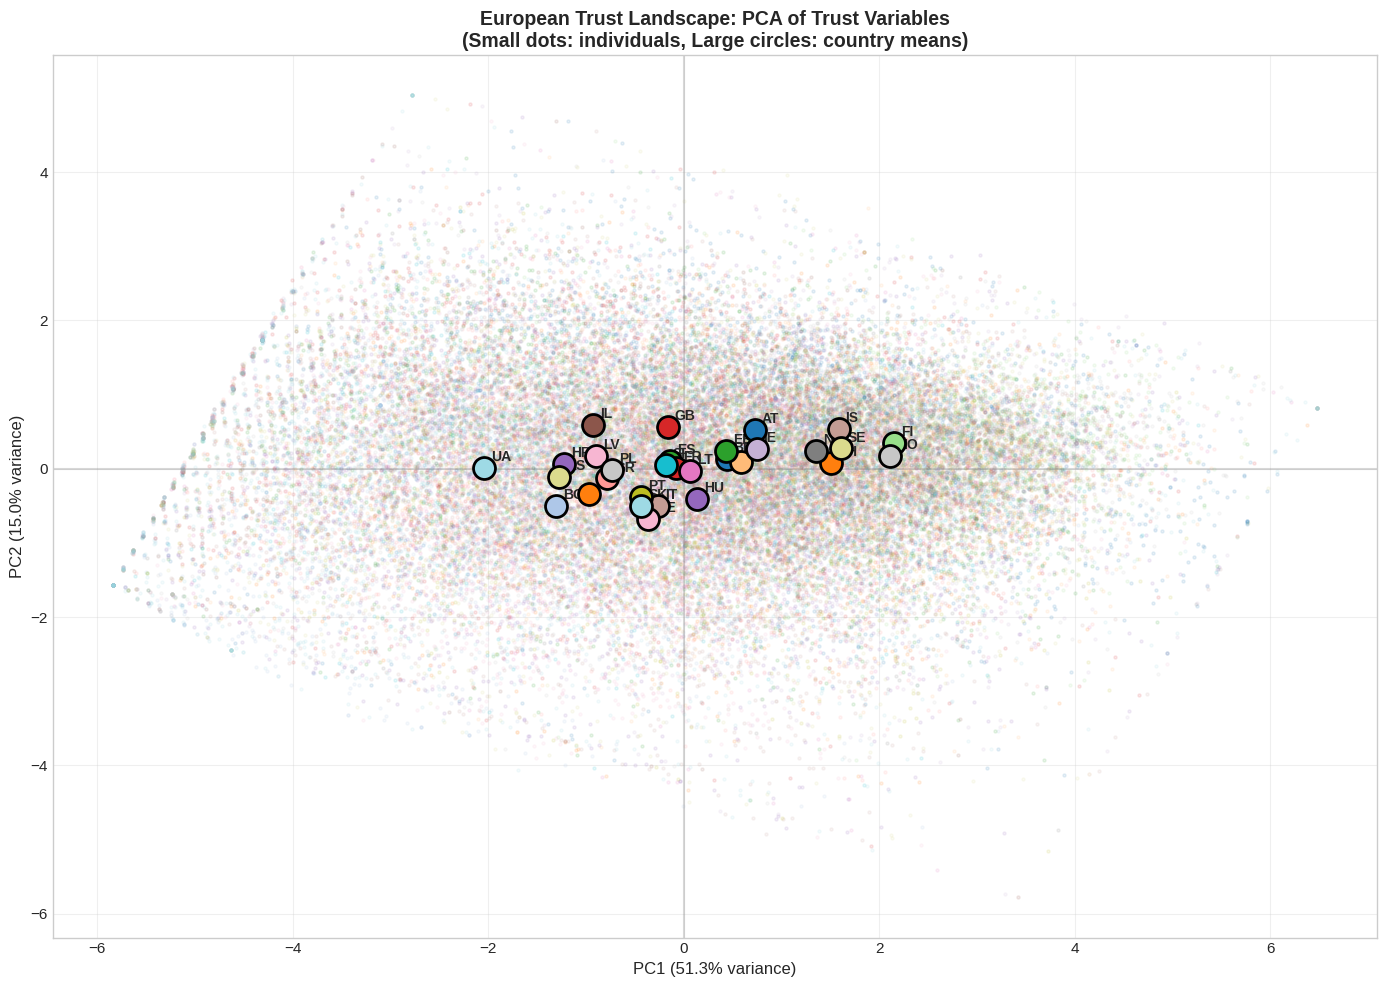

In [17]:
# Main scatter plot
fig, ax = plt.subplots(figsize=(14, 10))

unique_countries = df_pca['Country'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_countries)))
color_map = dict(zip(unique_countries, colors))

# Individual points
for country in unique_countries:
    mask = df_pca['Country'] == country
    ax.scatter(df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'],
               c=[color_map[country]], alpha=0.1, s=5)

# Country means
for _, row in country_means.iterrows():
    ax.scatter(row['PC1'], row['PC2'], c=[color_map[row['Country']]],
               s=250, edgecolors='black', linewidths=2, zorder=5)
    ax.annotate(row['Country'], (row['PC1'], row['PC2']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold')

ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title('European Trust Landscape: PCA of Trust Variables\n(Small dots: individuals, Large circles: country means)',
             fontsize=14, fontweight='bold')
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Biplot Visualization

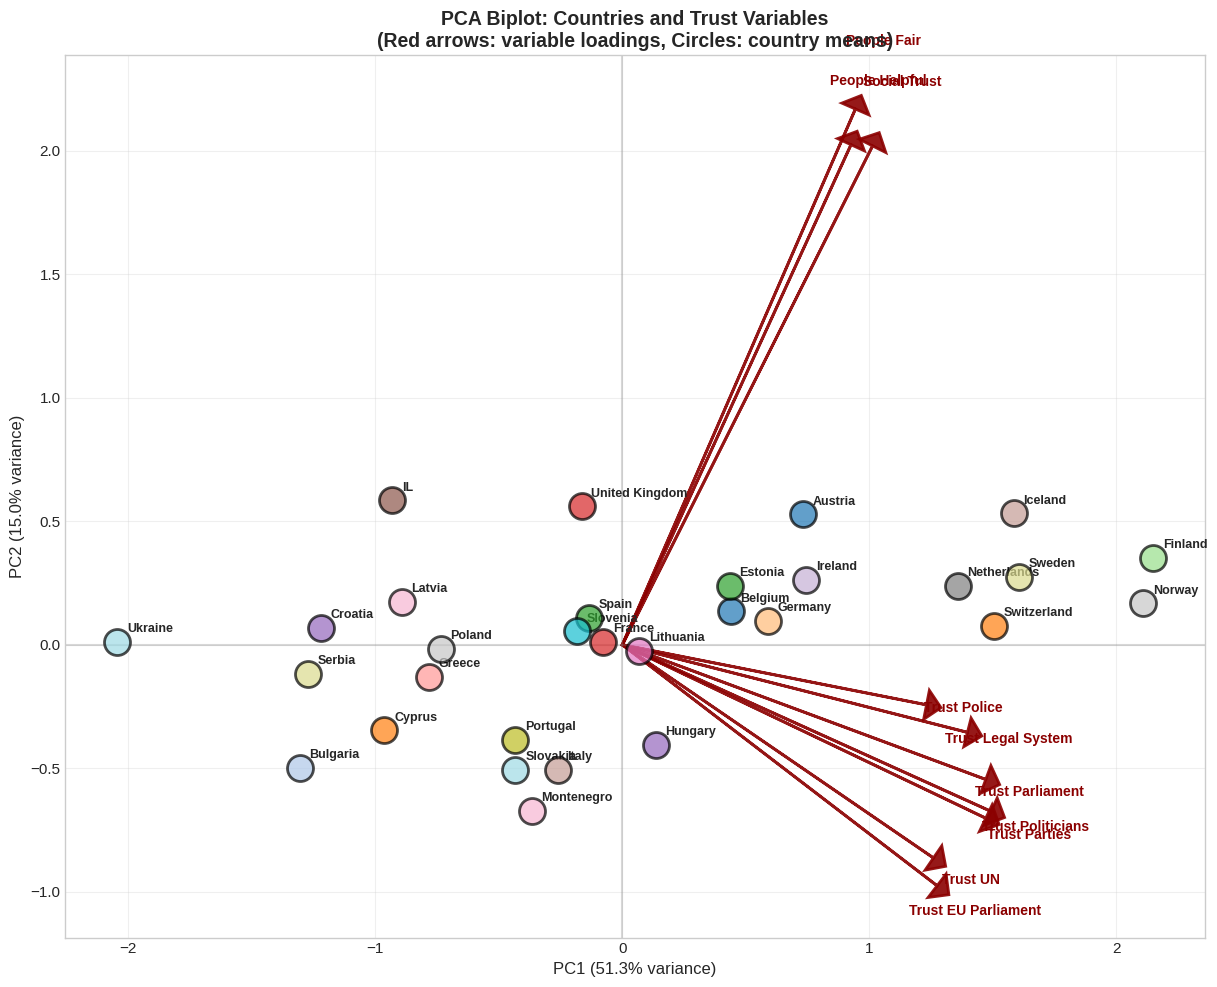

In [18]:
fig, ax = plt.subplots(figsize=(14, 10))

scale = 4  # Arrow scale factor

# Country means
for _, row in country_means.iterrows():
    ax.scatter(row['PC1'], row['PC2'], c=[color_map[row['Country']]],
               s=350, edgecolors='black', linewidths=2, alpha=0.7, zorder=5)
    name = row['Country_Name'] if pd.notna(row['Country_Name']) else row['Country']
    ax.annotate(name, (row['PC1'], row['PC2']),
                xytext=(7, 7), textcoords='offset points',
                fontsize=9, fontweight='bold')

# Variable loadings as arrows
loadings_2d = pca_2d.components_.T
for i, var in enumerate(trust_vars):
    ax.arrow(0, 0, loadings_2d[i, 0]*scale, loadings_2d[i, 1]*scale,
             head_width=0.12, head_length=0.06, fc='darkred', ec='darkred', alpha=0.9, linewidth=2)
    ax.text(loadings_2d[i, 0]*scale*1.12, loadings_2d[i, 1]*scale*1.12,
            var_labels[var], fontsize=10, color='darkred', ha='center', fontweight='bold')

ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title('PCA Biplot: Countries and Trust Variables\n(Red arrows: variable loadings, Circles: country means)',
             fontsize=14, fontweight='bold')
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

## 10. Country Comparison

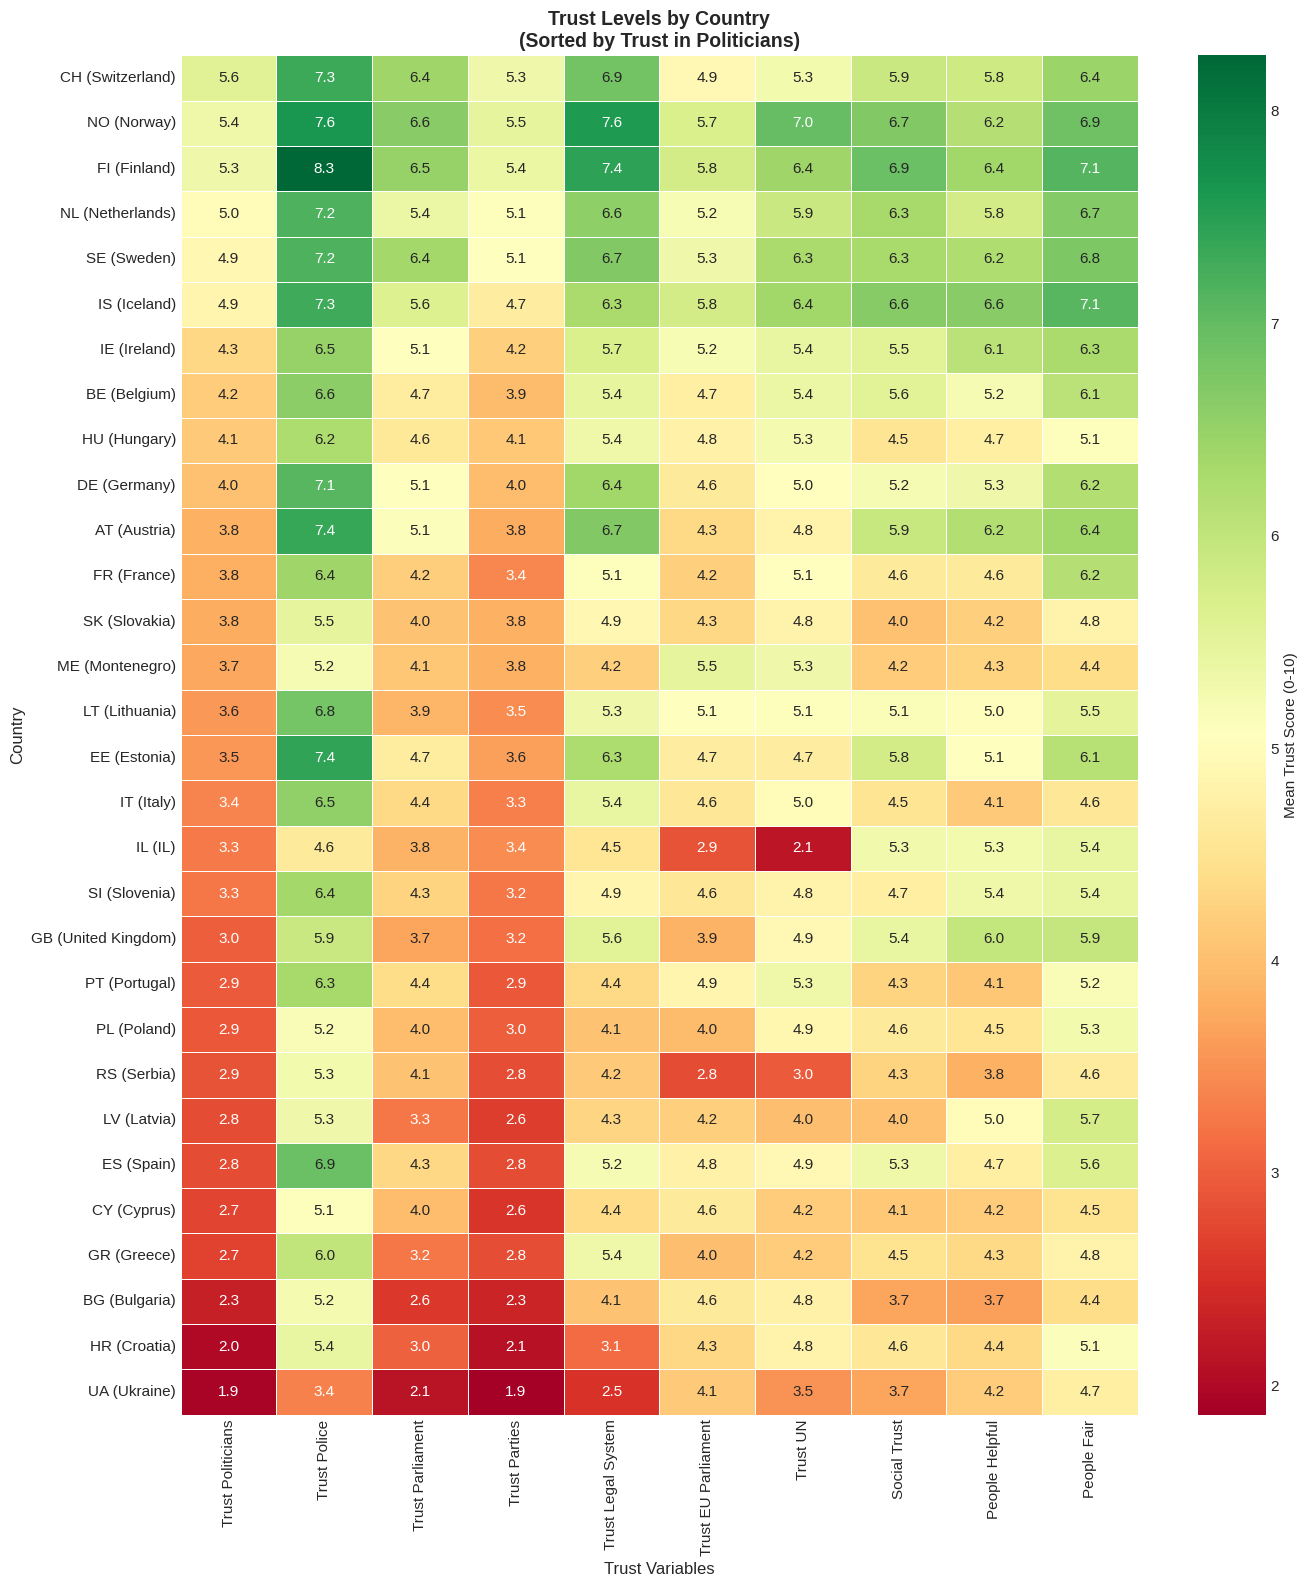

In [19]:
# Mean trust scores by country
country_trust_means = df_complete.groupby('cntry')[trust_vars].mean()
country_trust_means.columns = [var_labels[v] for v in trust_vars]
country_trust_means = country_trust_means.sort_values('Trust Politicians', ascending=False)

# Add country names
country_trust_means.index = [f"{idx} ({country_names.get(idx, idx)})" for idx in country_trust_means.index]

# Heatmap
fig, ax = plt.subplots(figsize=(14, 16))
sns.heatmap(country_trust_means, annot=True, fmt='.1f', cmap='RdYlGn',
            ax=ax, cbar_kws={'label': 'Mean Trust Score (0-10)'},
            linewidths=0.5)
ax.set_title('Trust Levels by Country\n(Sorted by Trust in Politicians)', fontsize=14, fontweight='bold')
ax.set_xlabel('Trust Variables', fontsize=12)
ax.set_ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()

## 11. Correlation Structure

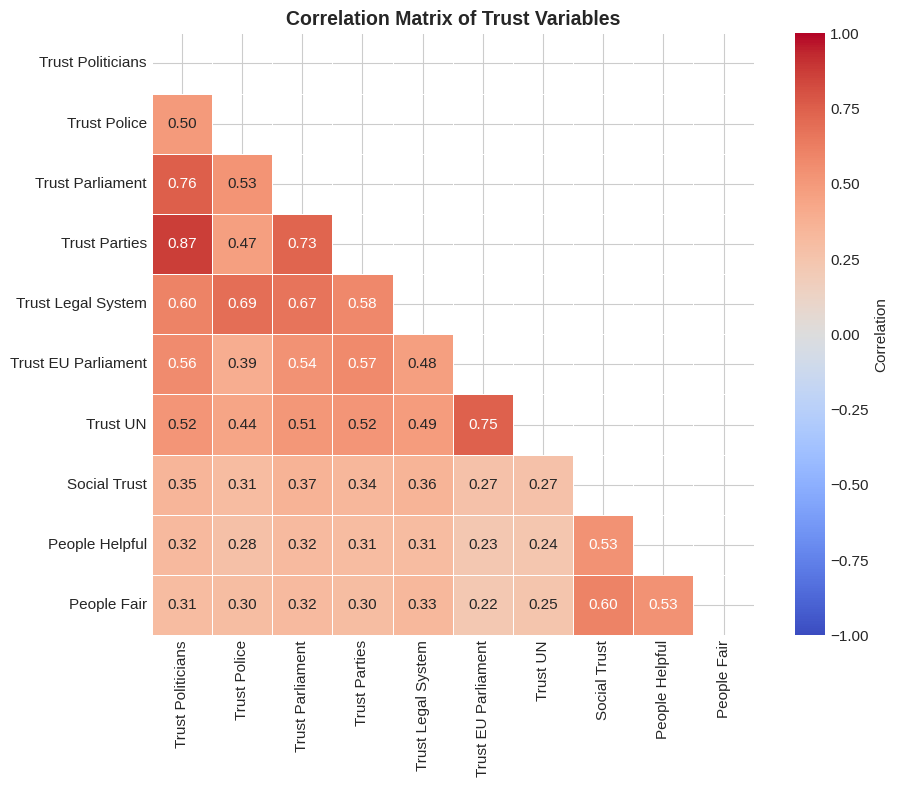

In [20]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
corr = df_complete[trust_vars].corr()
corr.columns = [var_labels[v] for v in trust_vars]
corr.index = [var_labels[v] for v in trust_vars]

mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, ax=ax, square=True,
            cbar_kws={'label': 'Correlation'}, linewidths=0.5)
ax.set_title('Correlation Matrix of Trust Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 12. Summary and Conclusions

In [21]:
print("="*70)
print("ANALYSIS SUMMARY")
print("="*70)
print(f"""
DATA OVERVIEW:
- Total respondents analyzed: {len(df_complete):,}
- Countries included: {df_complete['cntry'].nunique()}
- Variables: {len(trust_vars)} trust-related measures

PCA RESULTS:
- PC1 explains {explained_var[0]*100:.1f}% of variance
- PC2 explains {explained_var[1]*100:.1f}% of variance
- First {n_kaiser} components (Kaiser criterion) explain {cumulative_var[n_kaiser-1]*100:.1f}% of total variance

KEY FINDINGS:

1. DIMENSION STRUCTURE:
   - PC1 captures GENERAL TRUST (all variables load positively)
     → People who trust one institution tend to trust others
   
   - PC2 distinguishes INSTITUTIONAL vs SOCIAL trust
     → Political/institutional trust vs interpersonal trust

2. COUNTRY PATTERNS:
   - Nordic countries tend to show higher trust levels
   - Some Eastern European countries show lower institutional trust
   - Social trust patterns differ from political trust patterns

3. VARIABLE CLUSTERING:
   - Political trust cluster: politicians, parties, parliament
   - Social trust cluster: ppltrst, pplfair, pplhlp
   - Police/legal system: bridge both clusters

METHODOLOGY:
- Complete case analysis (listwise deletion)
- Standardized data (z-scores)
- Kaiser criterion for component retention
- Varimax rotation for Factor Analysis comparison
""")

ANALYSIS SUMMARY

DATA OVERVIEW:
- Total respondents analyzed: 43,744
- Countries included: 30
- Variables: 10 trust-related measures

PCA RESULTS:
- PC1 explains 51.3% of variance
- PC2 explains 15.0% of variance
- First 2 components (Kaiser criterion) explain 66.3% of total variance

KEY FINDINGS:

1. DIMENSION STRUCTURE:
   - PC1 captures GENERAL TRUST (all variables load positively)
     → People who trust one institution tend to trust others
   
   - PC2 distinguishes INSTITUTIONAL vs SOCIAL trust
     → Political/institutional trust vs interpersonal trust

2. COUNTRY PATTERNS:
   - Nordic countries tend to show higher trust levels
   - Some Eastern European countries show lower institutional trust
   - Social trust patterns differ from political trust patterns

3. VARIABLE CLUSTERING:
   - Political trust cluster: politicians, parties, parliament
   - Social trust cluster: ppltrst, pplfair, pplhlp
   - Police/legal system: bridge both clusters

METHODOLOGY:
- Complete case analys

---

**Conclusion**: This dimensional reduction analysis reveals that trust in European societies can be understood through two main dimensions: (1) a general trust factor capturing overall trust propensity, and (2) a dimension distinguishing institutional/political trust from interpersonal/social trust. These findings are consistent with social capital theory and highlight meaningful cross-national variation in trust structures.